In [2]:
from google.colab import drive
drive.mount('/content/drive/', timeout_ms=1000000)

Mounted at /content/drive/


In [3]:
%cd /content/drive/My\ Drive/Image Captioning/

/content/drive/My Drive/Image Captioning


In [113]:
import numpy as np
import os
from time import time
import matplotlib.pyplot as plt
import pickle 
import joblib
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2
import cv2 as cv
import gensim
from gensim.models import KeyedVectors
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
def unpickle_file(filepath):
  with open(filepath,'rb') as f:
    return pickle.load(f)
    

In [6]:
unq_wrds_dict_path = os.path.join(os.getcwd(),'dict_pkl','wrds_no_thresh.pkl')
# print(unq_wrds_dict_path)

unique_wrds_dict = unpickle_file(unq_wrds_dict_path)
print(f'Length of the unique words : {len(unique_wrds_dict.keys())}')


Length of the unique words : 7688


In [7]:
print(unique_wrds_dict)


{'child': 1161, 'in': 14058, 'pink': 484, 'dress': 227, 'is': 6996, 'climbing': 354, 'up': 945, 'set': 74, 'of': 5016, 'stairs': 77, 'an': 1785, 'entry': 1, 'way': 44, 'girl': 2340, 'going': 116, 'into': 773, 'wooden': 199, 'building': 371, 'little': 1318, 'playhouse': 6, 'the': 13699, 'to': 2334, 'her': 852, 'cabin': 4, 'black': 2875, 'dog': 6054, 'and': 6591, 'spotted': 26, 'are': 2565, 'fighting': 86, 'tricolored': 13, 'playing': 1470, 'with': 5717, 'each': 325, 'other': 570, 'on': 7899, 'road': 299, 'white': 2992, 'brown': 1912, 'spots': 23, 'staring': 39, 'at': 2156, 'street': 674, 'two': 4109, 'dogs': 1626, 'different': 30, 'breeds': 5, 'looking': 552, 'pavement': 40, 'moving': 31, 'toward': 106, 'covered': 234, 'paint': 40, 'sits': 440, 'front': 1024, 'painted': 49, 'rainbow': 13, 'hands': 185, 'bowl': 15, 'sitting': 969, 'large': 918, 'small': 919, 'grass': 1188, 'plays': 385, 'fingerpaints': 1, 'canvas': 6, 'it': 285, 'there': 230, 'pigtails': 13, 'painting': 29, 'young': 1912

In [8]:
# creating the word2index and index2word dictionary.

wrd2idx = {}          # dict of word as key and val as idx
idx2wrd = {}          # dict of idx as key and wrd as val 

start = time()
for i,keys in enumerate(unique_wrds_dict.keys(),1):
  wrd2idx[keys] = i;
  idx2wrd[i] = keys

print(time()-start)

print(f'Length of the word2idx is : {len(wrd2idx.keys())+1}')                # adding +1 because for wrds that not present in wrd2idx we initialize as 0.
print(f'Length of the idx2wrd is : {len(idx2wrd.keys())+1}')


0.002447366714477539
Length of the word2idx is : 7689
Length of the idx2wrd is : 7689


In [ ]:
print(idx2wrd)

{1: 'child', 2: 'in', 3: 'pink', 4: 'dress', 5: 'is', 6: 'climbing', 7: 'up', 8: 'set', 9: 'of', 10: 'stairs', 11: 'an', 12: 'entry', 13: 'way', 14: 'girl', 15: 'going', 16: 'into', 17: 'wooden', 18: 'building', 19: 'little', 20: 'playhouse', 21: 'the', 22: 'to', 23: 'her', 24: 'cabin', 25: 'black', 26: 'dog', 27: 'and', 28: 'spotted', 29: 'are', 30: 'fighting', 31: 'tricolored', 32: 'playing', 33: 'with', 34: 'each', 35: 'other', 36: 'on', 37: 'road', 38: 'white', 39: 'brown', 40: 'spots', 41: 'staring', 42: 'at', 43: 'street', 44: 'two', 45: 'dogs', 46: 'different', 47: 'breeds', 48: 'looking', 49: 'pavement', 50: 'moving', 51: 'toward', 52: 'covered', 53: 'paint', 54: 'sits', 55: 'front', 56: 'painted', 57: 'rainbow', 58: 'hands', 59: 'bowl', 60: 'sitting', 61: 'large', 62: 'small', 63: 'grass', 64: 'plays', 65: 'fingerpaints', 66: 'canvas', 67: 'it', 68: 'there', 69: 'pigtails', 70: 'painting', 71: 'young', 72: 'outside', 73: 'man', 74: 'lays', 75: 'bench', 76: 'while', 77: 'his', 

In [9]:
# adding the <start> and <end> tag idx to wrd2idx and idx2wrd
wrd2idx['<start>']=7689
wrd2idx['<end>']=7690

idx2wrd[7689] = '<start>'
idx2wrd[7690] = '<end>'

In [10]:
print(f'Length of the word2idx is : {len(wrd2idx.keys())+1}')              
print(f'Length of the idx2wrd is : {len(idx2wrd.keys())+1}')

Length of the word2idx is : 7691
Length of the idx2wrd is : 7691


In [11]:
print(wrd2idx)
print("===="*40)
print(idx2wrd)

{'child': 1, 'in': 2, 'pink': 3, 'dress': 4, 'is': 5, 'climbing': 6, 'up': 7, 'set': 8, 'of': 9, 'stairs': 10, 'an': 11, 'entry': 12, 'way': 13, 'girl': 14, 'going': 15, 'into': 16, 'wooden': 17, 'building': 18, 'little': 19, 'playhouse': 20, 'the': 21, 'to': 22, 'her': 23, 'cabin': 24, 'black': 25, 'dog': 26, 'and': 27, 'spotted': 28, 'are': 29, 'fighting': 30, 'tricolored': 31, 'playing': 32, 'with': 33, 'each': 34, 'other': 35, 'on': 36, 'road': 37, 'white': 38, 'brown': 39, 'spots': 40, 'staring': 41, 'at': 42, 'street': 43, 'two': 44, 'dogs': 45, 'different': 46, 'breeds': 47, 'looking': 48, 'pavement': 49, 'moving': 50, 'toward': 51, 'covered': 52, 'paint': 53, 'sits': 54, 'front': 55, 'painted': 56, 'rainbow': 57, 'hands': 58, 'bowl': 59, 'sitting': 60, 'large': 61, 'small': 62, 'grass': 63, 'plays': 64, 'fingerpaints': 65, 'canvas': 66, 'it': 67, 'there': 68, 'pigtails': 69, 'painting': 70, 'young': 71, 'outside': 72, 'man': 73, 'lays': 74, 'bench': 75, 'while': 76, 'his': 77, 

In [12]:
# considering the max_length of the caption in training data
def max_length_caption(train_caption):
  max_length = 0
  max_length_cap = ''

  for caption in train_caption.values():
    for ech_cap in caption:
      if(len(ech_cap.split())>max_length):
        max_length = len(ech_cap.split())
        max_length_cap = ech_cap


  return max_length,max_length_cap


In [13]:
train_dict_tags = unpickle_file(os.path.join(os.getcwd(),'dict_pkl','train_dict_tags.pkl'))

In [14]:
print(train_dict_tags)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
max_length, max_length_capt = max_length_caption(train_dict_tags)
print(f'Max length : {max_length}')
print(f'Max Length Caption: {max_length_capt}')         


Max length : 34
Max Length Caption: <start> an africanamerican man wearing green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on busy sidewalk in front of group of men playing instruments <end>


In [16]:
vocab_size = len(wrd2idx) + 1
print(vocab_size)

7691


#**Data Generator**

In [18]:
# defining the data generator function for the batch_size.

def data_generator_func(descriptions, img_embedd, word2idx, max_length, img_per_batch, vocab_size):

  X1, X2, y = list(), list(), list()
  n = int(0)

  while(True):

    for (img_id,cap_lst) in descriptions.items():             # here cap is a list of 5 captions w.r.t that particular image id.
      n+=1
      img_vec = img_embedd[img_id]                          # extracting the embedding of img from img_embedd dict.
      for captions in cap_lst:
        seq = [word2idx[wrd] for wrd in captions.split() if wrd in word2idx.keys()]

        for k in range(1, len(seq)):
          input_seq, output_seq = seq[:k], seq[k]            # split it into input and output seq.
          input_seq = pad_sequences([input_seq], maxlen= max_length)[0]       # pad sequences with zeros to max_length in order to standarize .

          output_seq = to_categorical([output_seq], num_classes= vocab_size)[0]            # do the necessary on hot encoding for the idx.

          X1.append(img_vec)
          X2.append(input_seq)
          y.append(output_seq)

      if n==img_per_batch:
        yield [[np.array(X1),np.array(X2)], np.array(y)]
        X1, X2, y = list(), list(), list()
        n=0

  

#**Taking Word2Vec Embeddings**

In [ ]:
wv_embeddings = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',binary=True)

In [22]:
wv_unique_embedd = np.zeros((vocab_size,300))
start = time()

for (wrd,idx) in wrd2idx.items():
  if wrd in wv_embeddings:
    wv_unique_embedd[idx] = wv_embeddings[wrd]

print(time()-start)
print(f'Shape of the wv_unique_embedding Matrix: {wv_unique_embedd.shape}')


0.02790522575378418
Shape of the wv_unique_embedding Matrix: (7691, 300)


#**Generator LSTM Model**

![alt text](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)


In [76]:
'''
We already save our (2048,) image embeddings in a dict and now we start
creating our LSTM model for captioning of the image on the basis of image 
encodings. Here we take the word2vec Embeddings of dimenison equal to 300.

'''
# capturing the image encodings.

input1 = Input(shape=(2048,))
drop1 = Dropout(0.5)(input1)
dense1 = Dense(256, activation='relu')(drop1)


# LSTM model for the captions generator.
# unique_wrds here is vocab size and mask_zero=True for padding with zeros.
# merge the image_encoding with caption embedding.

input2 = Input(shape=(max_length,))
layer1 = Embedding(vocab_size, 300, mask_zero=True)(input2)                     
lstm1 = LSTM(256, activation='tanh', return_sequences=True)(layer1)
drop4 = Dropout(0.5)(lstm1)
lstm2 = LSTM(256, activation='tanh')(drop4)
drop5 = Dropout(0.5)(lstm2)

merge = add([dense1,drop5])     

dense2 = Dense(512, activation="relu")(merge)
drop6 = Dropout(0.45)(dense2)
output = Dense(vocab_size, activation="softmax")(drop6)

# overall model by combining two.
model = Model(inputs=[input1, input2], outputs= output)



In [77]:
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 34, 300)      2307300     input_22[0][0]                   
__________________________________________________________________________________________________
lstm_24 (LSTM)                  (None, 34, 256)      570368      embedding_11[0][0]               
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 2048)         0                                            
____________________________________________________________________________________________

In [78]:
model.layers[1]

In [79]:
model.layers[1].set_weights([wv_unique_embedd])          # setting the weights as an embeddings which is passed theough lstm.
model.layers[1].trainable=False                           # we don't want to train our weights.

In [80]:
# compile our model having optimizer is adam, loss is categorical_crossentropy and metrics is accuracy|
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 


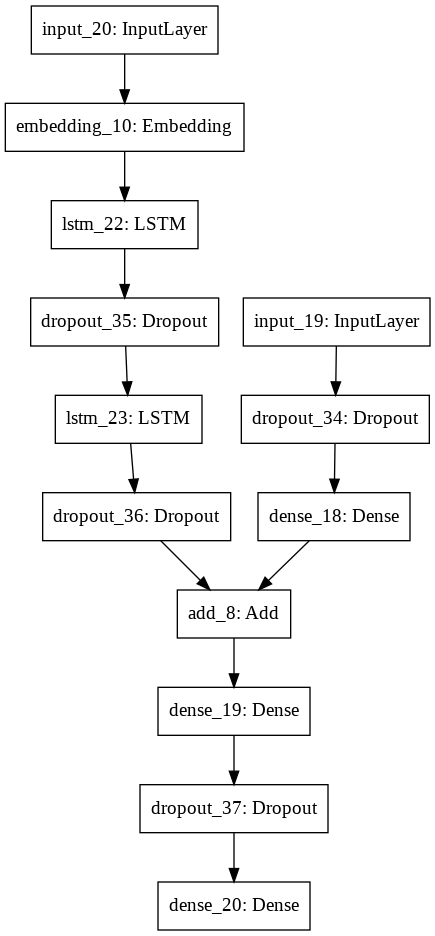

In [49]:
plot_model(model=model, to_file='model_Structure.png')

In [50]:
train_dict_tags = unpickle_file(os.path.join(os.getcwd(),'dict_pkl','train_dict_tags.pkl'))
img_encodings = unpickle_file(os.path.join(os.getcwd(),'Image_encodings','train_encodings.pkl'))

#**Model Training**

In [51]:
# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [52]:
epochs = 10
img_per_batch = 64
steps = len(train_dict_tags)//img_per_batch

In [71]:
for i in range(epochs):
  generator = data_generator_func(train_dict_tags, img_encodings, wrd2idx, max_length, img_per_batch, vocab_size)
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)

Epoch 1/1
93/93 [==============================] - 67s 723ms/step - loss: 4.5475 - accuracy: 0.2308
Epoch 1/1
93/93 [==============================] - 65s 703ms/step - loss: 4.1261 - accuracy: 0.2495
Epoch 1/1
93/93 [==============================] - 66s 709ms/step - loss: 4.0079 - accuracy: 0.2581
Epoch 1/1
93/93 [==============================] - 66s 705ms/step - loss: 3.9128 - accuracy: 0.2663
Epoch 1/1
93/93 [==============================] - 66s 709ms/step - loss: 3.8369 - accuracy: 0.2730
Epoch 1/1
93/93 [==============================] - 66s 706ms/step - loss: 3.7724 - accuracy: 0.2782
Epoch 1/1
93/93 [==============================] - 66s 708ms/step - loss: 3.7183 - accuracy: 0.2830
Epoch 1/1
93/93 [==============================] - 66s 705ms/step - loss: 3.6755 - accuracy: 0.2872
Epoch 1/1
93/93 [==============================] - 66s 709ms/step - loss: 3.6256 - accuracy: 0.2908
Epoch 1/1
93/93 [==============================] - 66s 710ms/step - loss: 3.5900 - accuracy: 0.2940


In [72]:
for i in range(epochs):
  generator = data_generator_func(train_dict_tags, img_encodings, wrd2idx, max_length, img_per_batch, vocab_size)
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)

Epoch 1/1
93/93 [==============================] - 66s 706ms/step - loss: 3.5667 - accuracy: 0.2967
Epoch 1/1
93/93 [==============================] - 66s 707ms/step - loss: 3.5288 - accuracy: 0.2995
Epoch 1/1
93/93 [==============================] - 66s 705ms/step - loss: 3.5016 - accuracy: 0.3015
Epoch 1/1
93/93 [==============================] - 65s 704ms/step - loss: 3.4824 - accuracy: 0.3037
Epoch 1/1
93/93 [==============================] - 65s 704ms/step - loss: 3.4555 - accuracy: 0.3064
Epoch 1/1
93/93 [==============================] - 66s 706ms/step - loss: 3.4378 - accuracy: 0.3086
Epoch 1/1
93/93 [==============================] - 66s 705ms/step - loss: 3.4133 - accuracy: 0.3100
Epoch 1/1
93/93 [==============================] - 66s 705ms/step - loss: 3.3995 - accuracy: 0.3127
Epoch 1/1
93/93 [==============================] - 65s 704ms/step - loss: 3.3784 - accuracy: 0.3140
Epoch 1/1
93/93 [==============================] - 66s 708ms/step - loss: 3.3698 - accuracy: 0.3150


In [73]:
for i in range(epochs):
  generator = data_generator_func(train_dict_tags, img_encodings, wrd2idx, max_length, img_per_batch, vocab_size)
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)

Epoch 1/1
93/93 [==============================] - 66s 711ms/step - loss: 3.3511 - accuracy: 0.3170
Epoch 1/1
93/93 [==============================] - 66s 711ms/step - loss: 3.3339 - accuracy: 0.3177
Epoch 1/1
93/93 [==============================] - 66s 709ms/step - loss: 3.3303 - accuracy: 0.3191
Epoch 1/1
93/93 [==============================] - 66s 708ms/step - loss: 3.3121 - accuracy: 0.3211
Epoch 1/1
93/93 [==============================] - 66s 708ms/step - loss: 3.3022 - accuracy: 0.3213
Epoch 1/1
93/93 [==============================] - 66s 706ms/step - loss: 3.2905 - accuracy: 0.3222
Epoch 1/1
93/93 [==============================] - 66s 708ms/step - loss: 3.2810 - accuracy: 0.3232
Epoch 1/1
93/93 [==============================] - 66s 707ms/step - loss: 3.2687 - accuracy: 0.3244
Epoch 1/1
93/93 [==============================] - 66s 711ms/step - loss: 3.2594 - accuracy: 0.3264
Epoch 1/1
93/93 [==============================] - 66s 707ms/step - loss: 3.2501 - accuracy: 0.3262


In [74]:
for i in range(epochs):
  generator = data_generator_func(train_dict_tags, img_encodings, wrd2idx, max_length, img_per_batch, vocab_size)
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)

Epoch 1/1
93/93 [==============================] - 66s 709ms/step - loss: 3.2508 - accuracy: 0.3273
Epoch 1/1
93/93 [==============================] - 66s 709ms/step - loss: 3.2358 - accuracy: 0.3284
Epoch 1/1
93/93 [==============================] - 66s 707ms/step - loss: 3.2304 - accuracy: 0.3290
Epoch 1/1
93/93 [==============================] - 66s 708ms/step - loss: 3.2201 - accuracy: 0.3295
Epoch 1/1
93/93 [==============================] - 66s 705ms/step - loss: 3.2108 - accuracy: 0.3305
Epoch 1/1
93/93 [==============================] - 66s 707ms/step - loss: 3.2051 - accuracy: 0.3315
Epoch 1/1
93/93 [==============================] - 66s 706ms/step - loss: 3.2001 - accuracy: 0.3320
Epoch 1/1
93/93 [==============================] - 65s 704ms/step - loss: 3.1915 - accuracy: 0.3323
Epoch 1/1
93/93 [==============================] - 66s 707ms/step - loss: 3.1871 - accuracy: 0.3328
Epoch 1/1
93/93 [==============================] - 66s 707ms/step - loss: 3.1816 - accuracy: 0.3343


In [75]:
model.save_weights('Model_Weights/model-1.h5')

In [81]:
model.load_weights('Model_Weights/model-1.h5')

In [82]:
model.optimizer.learning_rate = 0.001
epochs=10
img_per_batch =64
steps = len(train_dict_tags)//img_per_batch

In [83]:
for i in range(epochs):
  generator = data_generator_func(train_dict_tags, img_encodings, wrd2idx, max_length, img_per_batch, vocab_size)
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)

Epoch 1/1
93/93 [==============================] - 66s 709ms/step - loss: 3.2027 - accuracy: 0.3325
Epoch 1/1
93/93 [==============================] - 65s 696ms/step - loss: 3.1792 - accuracy: 0.3337
Epoch 1/1
93/93 [==============================] - 64s 692ms/step - loss: 3.1731 - accuracy: 0.3354
Epoch 1/1
93/93 [==============================] - 65s 697ms/step - loss: 3.1610 - accuracy: 0.3358
Epoch 1/1
93/93 [==============================] - 65s 694ms/step - loss: 3.1615 - accuracy: 0.3370
Epoch 1/1
93/93 [==============================] - 64s 688ms/step - loss: 3.1502 - accuracy: 0.3374
Epoch 1/1
93/93 [==============================] - 64s 690ms/step - loss: 3.1478 - accuracy: 0.3375
Epoch 1/1
93/93 [==============================] - 65s 696ms/step - loss: 3.1415 - accuracy: 0.3373
Epoch 1/1
93/93 [==============================] - 64s 692ms/step - loss: 3.1373 - accuracy: 0.3391
Epoch 1/1
93/93 [==============================] - 64s 693ms/step - loss: 3.1306 - accuracy: 0.3394


In [114]:
model.save_weights('Model_Weights/model-2.h5')

In [ ]:
model.load_weights('Model_Weights/model-2.h5')

In [ ]:
# saving the model in json format.

from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", 'w') as json_file:
  json_file.write(model_json)


In [56]:
val_tags = unpickle_file(os.path.join(os.getcwd(),'dict_pkl','val_dict.pkl'))
val_images_embedd = unpickle_file(os.path.join(os.getcwd(),'Image_encodings','val_encodings.pkl'))

In [ ]:
print(f'Shape of val_tags: {len(val_tags)}')
print(f'Shape of val_images_embedd: {len(val_images_embedd)}')

Shape of val_tags: 1091
Shape of val_images_embedd: 1091


In [101]:
print(val_tags['3509575615_653cbf01fc.jpg'])

['crowd is standing in front of building while holding newspapers and holding flags', 'adults and children demonstrating in town', 'group of people holding red flags and pamphlets in front of large building', 'group of people stand together holding papers and flags', 'people supporting cause']


#**Model Results**

In [57]:
# predicting the captions: Using Greedy search

def predict_caption(image_encoding):
  caption = ['<start>']
  for i in range(max_length):
    sequence = [wrd2idx[i] for i in caption]
    sequence = pad_sequences([sequence],  maxlen=max_length)
    predict_encode = model.predict([image_encoding,sequence], verbose=0)
    predict_encode = np.argmax(predict_encode)            # get the encodinfg no. of the predicted image.
    predict_wrd = idx2wrd[predict_encode]

    caption.append(predict_wrd)

    if predict_wrd=='<end>':
      break

  return ' '.join(caption[1:-1])                      # extracting all words and except for <start> and <end> tag.


In [58]:
# General Formlua For the beam search. 
def beam_search_prediction(image, k):
  
  start = [wrd2idx['<start>']]
  start_wrd = [[start,0.0]]

  while len(start_wrd[0][0])<max_length:
    temp = []
    for m in start_wrd:
      caption = pad_sequences([m[0]], maxlen=max_length, padding='post')
      predict = model.predict([image,caption], verbose=0)

      # print(predict.shape)

      wrds_encoding = np.argsort(predict[0])[-k:]            # selecting the k: beam index. Selecting the last k values argsort in ascending order.
      
      for wrd in wrds_encoding:
        next_cap, prob = m[0][:], m[1]
        next_cap.append(wrd)
        prob += predict[0][wrd]
        temp.append([next_cap, prob])

      # print(temp)                  # checking 

      start_wrd = temp
      # sortinh the conditional probability of wrds and the greatest one.
      start_wrd = sorted(start_wrd, reverse=False, key=lambda x: x[1])
      start_wrd = start_wrd[-k:]

  
  start_wrd = start_wrd[-1][0]
  intermediate_caption = [idx2wrd[i] for i in start_wrd]

  final_caption = []

  for i in intermediate_caption:
    if i!='<end>':
      final_caption.append(i)

    else:
      break

  final_caption = ' '.join(final_caption[1:])
  return final_caption


In [97]:
def visualize_image(path):
  img = cv.imread(path)
  img_rgb = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  return cv.resize(img_rgb,(299,299),interpolation = cv.INTER_CUBIC)

In [117]:
def predicting_output(model, img_no):

  image_name = list(val_images_embedd.keys())[img_no]
  image_emb = val_images_embedd[image_name]
  true_img_captioning = val_tags[image_name]        # list of all actual image captions.

  image_emb = np.reshape(image_emb, (1,2048))
  assert image_emb.shape == (1,2048)

  # plotting image
  plt.figure(figsize=(10,8))
  plt.imshow(visualize_image(os.path.join(os.getcwd(),'Images',image_name)))
  plt.axis('off')
  plt.show()

  references = list()
  # Calculating the references
  for img_cap in true_img_captioning:
    references.append(img_cap.split())

  # List of list of true image captions.
  assert len(references) == 5     


  greedy = predict_caption(image_emb)
  beam_k3 = beam_search_prediction(image_emb,3)
  beam_k5 = beam_search_prediction(image_emb,5)
  beam_k7 = beam_search_prediction(image_emb,7)

  
  out_sent = ['Greedy Search', 'Beam Search k=3', 'Beam Search k=5', 'Beam Search k=7']
  output = [greedy, beam_k3, beam_k5, beam_k7]

  for i in range(4):
    print('\n\n')
    print(f'{out_sent[i]}: \nPredicted Sentence: {output[i]}')
    hypothesis = output[i].split()
    
    print(f'Blue Score(N-gram-1):  {sentence_bleu(references, hypothesis, weights=(1,0,0,0))}')
    print(f'Blue Score(N-gram-2):  {sentence_bleu(references, hypothesis, weights=(0.5,0.5,0,0) )}')
    print(f'Blue Score(N-gram-3):  {sentence_bleu(references, hypothesis, weights=(0.3,0.3,0.3,0) )}')
    print(f'Blue Score(N-gram-4):  {sentence_bleu(references, hypothesis, weights=(0.25,0.25,0.25,0.25) )}')

    '''
    Higher the blue score more close is the true_output with
    model predicted text.
    
    '''



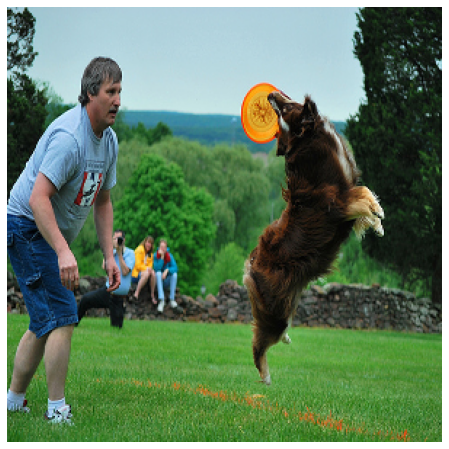




Greedy Search: 
Predicted Sentence: man is jumping to catch frisbee
Blue Score(N-gram-1):  0.5971094254781577
Blue Score(N-gram-2):  0.5066641486392106
Blue Score(N-gram-3):  0.38397962187466905
Blue Score(N-gram-4):  0.4260520663282873



Beam Search k=3: 
Predicted Sentence: black dog is jumping to catch frisbee
Blue Score(N-gram-1):  0.6191984998215584
Blue Score(N-gram-2):  0.4229931028018367
Blue Score(N-gram-3):  0.3477700219364014
Blue Score(N-gram-4):  0.40495158902656925



Beam Search k=5: 
Predicted Sentence: black dog is jumping up to catch frisbee
Blue Score(N-gram-1):  0.625
Blue Score(N-gram-2):  0.42257712736425823
Blue Score(N-gram-3):  0.3484161012993529
Blue Score(N-gram-4):  0.4153509237206396



Beam Search k=7: 
Predicted Sentence: brown dog is jumping up to catch frisbee
Blue Score(N-gram-1):  0.625
Blue Score(N-gram-2):  0.42257712736425823
Blue Score(N-gram-3):  0.3484161012993529
Blue Score(N-gram-4):  0.4153509237206396


In [118]:
predicting_output(model, 296)

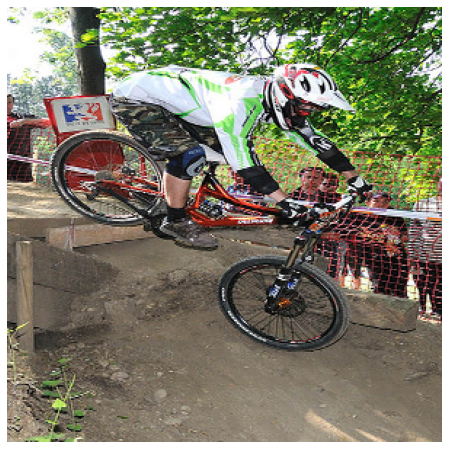




Greedy Search: 
Predicted Sentence: man in blue shirt is riding bike on the street
Blue Score(N-gram-1):  0.5
Blue Score(N-gram-2):  0.2357022603955158
Blue Score(N-gram-3):  0.4201634287291895
Blue Score(N-gram-4):  0.4854917717073234



Beam Search k=3: 
Predicted Sentence: man rides bike through the woods
Blue Score(N-gram-1):  0.5
Blue Score(N-gram-2):  0.316227766016838
Blue Score(N-gram-3):  0.5011872336272724
Blue Score(N-gram-4):  0.5623413251903491



Beam Search k=5: 
Predicted Sentence: man is riding his bike through the woods
Blue Score(N-gram-1):  0.5515605641153721
Blue Score(N-gram-2):  0.37292300600205397
Blue Score(N-gram-3):  0.5263283721767551
Blue Score(N-gram-4):  0.5736753417215604



Beam Search k=7: 
Predicted Sentence: man is riding bike in the woods
Blue Score(N-gram-1):  0.4294155960430205
Blue Score(N-gram-2):  0.568063438111202
Blue Score(N-gram-3):  0.6353374384520296
Blue Score(N-gram-4):  0.6533657281851002


In [120]:
predicting_output(model, 278)

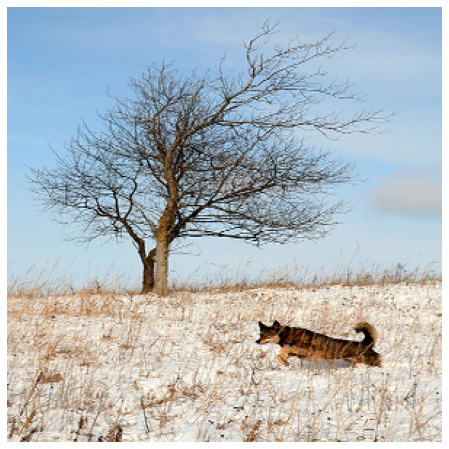




Greedy Search: 
Predicted Sentence: two dogs are running in the grass
Blue Score(N-gram-1):  0.42857142857142855
Blue Score(N-gram-2):  0.26726124191242434
Blue Score(N-gram-3):  0.4530661222656876
Blue Score(N-gram-4):  0.5169731539571706



Beam Search k=3: 
Predicted Sentence: two dogs play in the grass
Blue Score(N-gram-1):  0.5
Blue Score(N-gram-2):  0.316227766016838
Blue Score(N-gram-3):  0.5011872336272724
Blue Score(N-gram-4):  0.5623413251903491



Beam Search k=5: 
Predicted Sentence: two brown dogs are playing in the grass
Blue Score(N-gram-1):  0.5
Blue Score(N-gram-2):  0.26726124191242434
Blue Score(N-gram-3):  0.45306612226568754
Blue Score(N-gram-4):  0.5169731539571706



Beam Search k=7: 
Predicted Sentence: brown and white dog is running in the grass surrounded by bushes
Blue Score(N-gram-1):  0.5833333333333334
Blue Score(N-gram-2):  0.23028309323591914
Blue Score(N-gram-3):  0.41434035389004875
Blue Score(N-gram-4):  0.47987820666906633


In [121]:
predicting_output(model, 431)

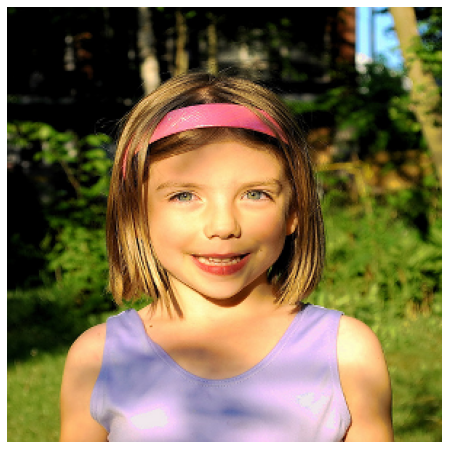




Greedy Search: 
Predicted Sentence: girl in pink shirt is smiling
Blue Score(N-gram-1):  0.7165313105737893
Blue Score(N-gram-2):  0.32044254369000136
Blue Score(N-gram-3):  0.4421240823231761
Blue Score(N-gram-4):  0.4791733671582712



Beam Search k=3: 
Predicted Sentence: little girl in pink shirt is standing in front of flowers
Blue Score(N-gram-1):  0.5454545454545454
Blue Score(N-gram-2):  0.2335496832484569
Blue Score(N-gram-3):  0.4178568918931313
Blue Score(N-gram-4):  0.4832697830906221



Beam Search k=5: 
Predicted Sentence: little girl in pink shirt is laughing
Blue Score(N-gram-1):  0.6191984998215584
Blue Score(N-gram-2):  0.2991012913863172
Blue Score(N-gram-3):  0.45779826807800617
Blue Score(N-gram-4):  0.5091996654452335



Beam Search k=7: 
Predicted Sentence: little girl in pink shirt is smiling in the grass
Blue Score(N-gram-1):  0.7
Blue Score(N-gram-2):  0.2788866755113585
Blue Score(N-gram-3):  0.4647898754006665
Blue Score(N-gram-4):  0.5280972216470737


In [123]:
predicting_output(model, 589)

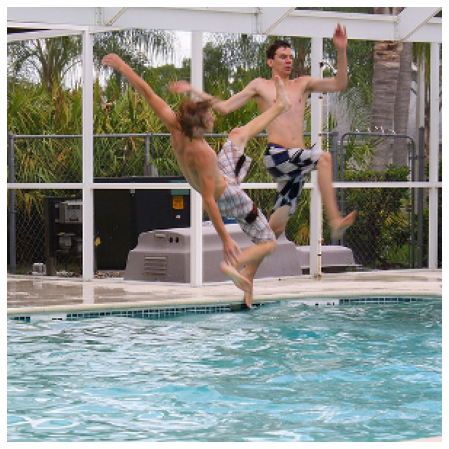




Greedy Search: 
Predicted Sentence: boy is jumping into pool
Blue Score(N-gram-1):  0.6
Blue Score(N-gram-2):  0.5477225575051662
Blue Score(N-gram-3):  0.5011872336272722
Blue Score(N-gram-4):  0.5623413251903491



Beam Search k=3: 
Predicted Sentence: boy is jumping into pool in pool
Blue Score(N-gram-1):  0.5714285714285714
Blue Score(N-gram-2):  0.4364357804719847
Blue Score(N-gram-3):  0.37519859868268624
Blue Score(N-gram-4):  0.4417918226831577



Beam Search k=5: 
Predicted Sentence: boy is jumping into pool in pool
Blue Score(N-gram-1):  0.5714285714285714
Blue Score(N-gram-2):  0.4364357804719847
Blue Score(N-gram-3):  0.37519859868268624
Blue Score(N-gram-4):  0.4417918226831577



Beam Search k=7: 
Predicted Sentence: boy jumping into swimming pool
Blue Score(N-gram-1):  0.8
Blue Score(N-gram-2):  0.7745966692414834
Blue Score(N-gram-3):  0.6170338627200096
Blue Score(N-gram-4):  0.668740304976422


In [124]:
predicting_output(model, 300)

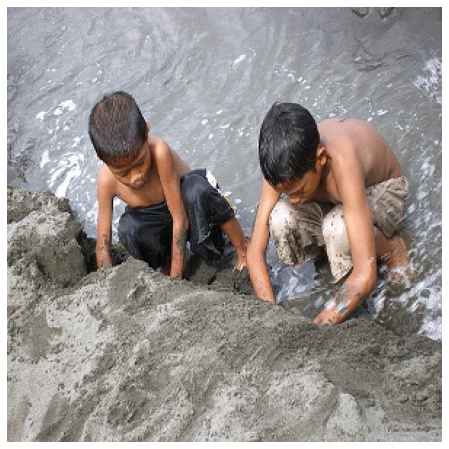




Greedy Search: 
Predicted Sentence: two boys are standing on the rocks
Blue Score(N-gram-1):  0.5714285714285714
Blue Score(N-gram-2):  0.4364357804719847
Blue Score(N-gram-3):  0.37519859868268624
Blue Score(N-gram-4):  0.4417918226831577



Beam Search k=3: 
Predicted Sentence: two boys are standing on the rocks in the water
Blue Score(N-gram-1):  0.7
Blue Score(N-gram-2):  0.557773351022717
Blue Score(N-gram-3):  0.4647898754006666
Blue Score(N-gram-4):  0.5280972216470737



Beam Search k=5: 
Predicted Sentence: two boys playing in the water at the shore
Blue Score(N-gram-1):  0.7777777777777778
Blue Score(N-gram-2):  0.6972166887783963
Blue Score(N-gram-3):  0.44925327564818096
Blue Score(N-gram-4):  0.5133450480401704



Beam Search k=7: 
Predicted Sentence: two boys sit on the rocks in the water at the beach
Blue Score(N-gram-1):  0.5
Blue Score(N-gram-2):  0.3692744729379982
Blue Score(N-gram-3):  0.27568273721198044
Blue Score(N-gram-4):  0.34172334076593075


In [127]:
predicting_output(model, 456)

#**Code-Check**

In [ ]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

In [ ]:
check2 = to_lines(train_dict)

In [ ]:
for i,(x,y) in enumerate(train_dict.items()):
  print(x)
  print(y)

  if(i==0):
    break

1000268201_693b08cb0e.jpg
['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [ ]:
array([1,2,3])